# Documentation

Tuto classif avec camembert : https://xiaoouwang.medium.com/classification-de-commentaires-avec-camembert-sans-prise-de-t%C3%AAte-les-fondamentaux-dbf8070f679b  
Tuto fine-tuning avec sentence-bert : https://h4c5.hashnode.dev/finetuner-un-modele-camembert-pour-lembedding-de-phrases  
Tuto fine-tuning Camembert pour NER : https://www.quantmetry.com/blog/fine-tune-modele-bert-tache-ner/  
Article expliquant les Transformers : https://www.hugomichel.io/post/transformer/  
Huggingface Camembert : https://huggingface.co/docs/transformers/model_doc/camembert#transformers.CamembertModel  
Article sur la fonction de coût pour classification multi-label : https://medium.com/@kitkat73275/multi-label-classification-8d8ae55e8373  
Implémentation de la fonction de coût dans un modèle DL : https://machinelearningmastery.com/multi-label-classification-with-deep-learning/  
Utilisation de torch.eval() pour bien évaluer un modèle pytroch : https://iifx.dev/en/articles/267524756  

In [1]:
!pip install transformers
!pip install sentencepiece
!pip install pandas
!pip install scikit-learn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 54.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 1.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 45.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 MB 24.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 47.4 MB/s eta 0:00:00


# Imports

In [99]:
# Misc
import os
import s3fs
from itertools import compress
import time
from math import ceil, floor
from sklearn.utils import shuffle

# pre-trained Model
from transformers import CamembertTokenizer, CamembertForSequenceClassification

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, accuracy_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Pytorch
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F

# Data

In [3]:
os.environ["AWS_S3_ENDPOINT"]
S3_ENDPOINT_URL  = 'https://'+os.environ['AWS_S3_ENDPOINT']
fs = s3fs.S3FileSystem(client_kwargs = {'endpoint_url' : S3_ENDPOINT_URL})
fs.ls('')

['nsimonovici-ensae']

In [4]:
BUCKET = "nsimonovici-ensae"
DIR_KEY_S3 = "PROJET/data/"
FILE_KEY_S3 = 'project-1-at-2024-12-27-15-41-3fe0002a_prepared.csv'
s3_path = f"s3a://{BUCKET}/{DIR_KEY_S3}{FILE_KEY_S3}"
s3_path

's3a://nsimonovici-ensae/PROJET/data/project-1-at-2024-12-27-15-41-3fe0002a_prepared.csv'

In [5]:
with fs.open(s3_path, mode = 'r') as file_in : 
    data_raw = pd.read_csv(file_in, sep=";")

print(f"{data_raw.shape[0]} Lignes et {data_raw.shape[1]} Colonnes")
data_raw.head()

1263 Lignes et 10 Colonnes


,inner_id,topic,topic_idx,data.text,data.name,file_upload,id,data.url,data.username,data.date
0,1,"[""social""]",[11],Stop #ViolenceAgainstWomen!\n\n#OrangeTheWorld...,L’Europe Ensemble,1de050d6-bluesky-comptes-politiques-2_.csv,1,https://bsky.app/profile/fabiennekeller.bsky.s...,ensembleue.bsky.social,2024-11-25 19:25:10.459000
1,2,"[""social""]",[11],La violence à l’égard des femmes reste une urg...,L’Europe Ensemble,1de050d6-bluesky-comptes-politiques-2_.csv,2,https://bsky.app/profile/mariepierrev.bsky.soc...,ensembleue.bsky.social,2024-11-25 19:24:48.661000
2,3,"[""international"",""économie""]","[8,3]","« Notre position sur le Mercosur, depuis 2019,...",L’Europe Ensemble,1de050d6-bluesky-comptes-politiques-2_.csv,3,https://bsky.app/profile/ensembleue.bsky.socia...,ensembleue.bsky.social,2024-11-25 13:42:39.117000
3,4,"[""international"",""économie"",""social""]","[8,3,11]",Nouvelle session plénière à Strasbourg ! À l’o...,L’Europe Ensemble,1de050d6-bluesky-comptes-politiques-2_.csv,4,https://bsky.app/profile/ensembleue.bsky.socia...,ensembleue.bsky.social,2024-11-25 12:59:05.431000
4,5,"[""international"",""immigration""]","[8,7]",Désaveu cinglant pour Meloni qui se résout à r...,L’Europe Ensemble,1de050d6-bluesky-comptes-politiques-2_.csv,5,https://bsky.app/profile/fabiennekeller.bsky.s...,ensembleue.bsky.social,2024-11-25 12:50:04.455000


In [8]:
# for param in model.parameters():
#     param.requires_grad = False

In [9]:
# print(f"num params:", model.num_parameters())
# print(f"num trainable params:", model.num_parameters(only_trainable=True))

# Fonction de coût :  
What you want is multi-label classification, so you will use Binary Cross-Entropy Loss or Sigmoid Cross-Entropy loss. It is a Sigmoid activation plus a Cross-Entropy loss. Unlike Softmax loss it is independent for each vector component (class), meaning that the loss computed for every CNN output vector component is not affected by other component values. That’s why it is used for multi-label classification, where the insight of an element belonging to a certain class should not influence the decision for another class.

Altération du model : couches de fine-tuning

In [10]:
# def get_finetuning_model(n_outputs):
# 	model = Sequential()
# 	model.out = Linear(n_outputs, activation='sigmoid')
# 	model.compile(loss='binary_crossentropy', optimizer='adam')
# 	return model

In [67]:
# model.fineTuning = get_finetuning_model(16)

# Fine-Tuning

### Définition de la seed pour répétabilité

In [109]:
random_state = 42

## Préparation des données
- Assurez-vous que vos données sont sous forme de texte et de labels multi-labels (par exemple, une liste de listes de labels).
- Tokenisez les textes et convertissez les labels en tenseurs PyTorch.

In [13]:
dict_labels_index = {'autre':0,
    'culture et médias':1,
    'environnement':2,
    'économie':3,
    'éducation':4,
    'fiscalité':5,
    'institutions':6,
    'immigration':7,
    'international':8,
    'outre-mer':9,
    'pouvoir d’achat':10,
    'social':11,
    'services publics':12,
    'santé':13,
    'sécurité / justice':14,
    'vie politique':15}

dict_index_labels = {value:key for key, value in dict_labels_index.items()}

In [14]:
texts = data_raw['data.text'].tolist()
print(len(texts))
texts[0]

1263


'Stop #ViolenceAgainstWomen!\n\n#OrangeTheWorld \n\n📍 Parlement européen, Strasbourg 🧡'

In [15]:
labels_arr = np.zeros((len(texts), 16))
labels_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1263, 16))

In [16]:
labels_raw = data_raw['topic_idx'].tolist()
labels_ints = []
for labs in labels_raw:
    labels_ints.append([int(value) for value in labs.replace('[', '').replace(']', '').split(',')])
labels_ints[:5]

[[11], [11], [8, 3], [8, 3, 11], [8, 7]]

In [17]:
for i in range(labels_arr.shape[0]):
    labs = labels_ints[i]
    for value in labs:
        labels_arr[i, value] = 1
labels_arr        

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], shape=(1263, 16))

In [18]:
labels_list = labels_arr.tolist()
labels_list[:5]

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]]

### Reconstitution du dataset en pandas et shuffle

In [24]:
df_labels = pd.DataFrame(labels_list, columns=dict_labels_index.keys())
df_labels.head()

,autre,culture et médias,environnement,économie,éducation,fiscalité,institutions,immigration,international,outre-mer,pouvoir d’achat,social,services publics,santé,sécurité / justice,vie politique
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
df_texts = pd.DataFrame(data=texts, columns=['text'])
df_texts.head()

,text
0,Stop #ViolenceAgainstWomen!\n\n#OrangeTheWorld...
1,La violence à l’égard des femmes reste une urg...
2,"« Notre position sur le Mercosur, depuis 2019,..."
3,Nouvelle session plénière à Strasbourg ! À l’o...
4,Désaveu cinglant pour Meloni qui se résout à r...


In [107]:
df_data = pd.concat((df_texts, df_labels), axis=1)
df_data.head()

,text,autre,culture et médias,environnement,économie,éducation,fiscalité,institutions,immigration,international,outre-mer,pouvoir d’achat,social,services publics,santé,sécurité / justice,vie politique
0,Stop #ViolenceAgainstWomen!\n\n#OrangeTheWorld...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,La violence à l’égard des femmes reste une urg...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,"« Notre position sur le Mercosur, depuis 2019,...",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Nouvelle session plénière à Strasbourg ! À l’o...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Désaveu cinglant pour Meloni qui se résout à r...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
df_data = shuffle(df_data, random_state=random_state).reset_index(drop=True)
df_data.head()

,text,autre,culture et médias,environnement,économie,éducation,fiscalité,institutions,immigration,international,outre-mer,pouvoir d’achat,social,services publics,santé,sécurité / justice,vie politique
0,Guerre en Ukraine : l’Allemagne va doubler son...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"✊ Aux côtés des syndicats, en soutien aux fonc...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,"""Un gouvernement de menteurs et d'incompétents...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,🚀 La dynamique est lancée !\n\nDans le sondage...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,"🌹 Une socialiste, un combat\n\nAvec les député...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [173]:
num_labels = df_data.shape[1] - 1
num_labels

16

### Split train/test/val

In [115]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df_data['text'].values, df_data.drop(columns=['text']).values, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=random_state)

print(f"Taille jeu d'entraînement = {len(X_train)}")
print(f"Taille jeu de validation = {len(X_val)}")
print(f"Taille jeu de test = {len(X_test)}")

Taille jeu d'entraînement = 909
Taille jeu de validation = 101
Taille jeu de test = 253


In [20]:
inputs_train = tokenizer(X_train, padding=True, truncation=True, return_tensors="pt")
labels_train = torch.tensor(y_train)
inputs_val = tokenizer(X_val, padding=True, truncation=True, return_tensors="pt")
labels_val = torch.tensor(y_val)
inputs_test = tokenizer(X_test, padding=True, truncation=True, return_tensors="pt")
labels_test = torch.tensor(y_test)

### Split manuel et répartition des classes

In [23]:
test_size = 0.2
train_size = 0.8 * 0.9
val_size = 0.8 * 0.1

In [25]:
df_labels[df_labels.loc[:, 'culture et médias'] == 1]

,autre,culture et médias,environnement,économie,éducation,fiscalité,institutions,immigration,international,outre-mer,pouvoir d’achat,social,services publics,santé,sécurité / justice,vie politique
28,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
357,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
521,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
618,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [174]:
df_labels[df_labels.loc[:, 'éducation'] == 1]

,autre,culture et médias,environnement,économie,éducation,fiscalité,institutions,immigration,international,outre-mer,pouvoir d’achat,social,services publics,santé,sécurité / justice,vie politique
183,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
198,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
322,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
330,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
383,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [175]:
df_labels[df_labels.loc[:, 'fiscalité'] == 1]

,autre,culture et médias,environnement,économie,éducation,fiscalité,institutions,immigration,international,outre-mer,pouvoir d’achat,social,services publics,santé,sécurité / justice,vie politique
151,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
265,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
339,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
609,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
619,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [170]:
df_labels.sum()

autre                 153.0
culture et médias      15.0
environnement          54.0
économie              138.0
éducation              19.0
fiscalité              18.0
institutions          173.0
immigration            26.0
international         214.0
outre-mer              35.0
pouvoir d’achat        43.0
social                244.0
services publics       15.0
santé                  42.0
sécurité / justice     67.0
vie politique         444.0
dtype: float64

In [171]:
df_labels.sum().apply(lambda x: round(x * train_size) + round(x * test_size) + round(x * val_size))

autre                 153
culture et médias      15
environnement          54
économie              138
éducation              20
fiscalité              18
institutions          174
immigration            26
international         214
outre-mer              35
pouvoir d’achat        43
social                245
services publics       15
santé                  41
sécurité / justice     66
vie politique         445
dtype: int64

In [168]:
15 * train_size, 15 * test_size, 15 * val_size

(10.8, 3.0, 1.2000000000000002)

#### Gestion des classes peu représentées

Je prends la classe services publics

Pour chaque tweet de la classe
    Je rempli x_train jusqu'à ce que le train_size pour cette classe soit atteint
    Je rempli ensuite x_val
    Je rempli ensuite x_test
Si le total des tailles des jeux dépasse la taille de la classe
    Si taille_jeux > taille_classe:
        Je prend un élément de x_train et je le mets dans x_test ?
    Sinon je rajoute ceux qui n'ont pas été pris dans x_test

OU ALORS POUR LES PETITES CLASSES JE NE FAIT PAS DE JEU DE VALIDATION ??

OU JE LAISSE TOMBER COMPLET LE JEU DE VALIDATION CAR PAS ASSEZ DE DONNEES ??

==> Dans ce cas je me contente d'un split train / test et je réparti les tweets dans chaque manuellement.
On va faire ça, tant pis pour les métriques intermédiaires

AUTRE PLAN : SUPPRIMER LES PETITES CLASSES ET LEURS TWEETS (< 20 OCCURENCES)

#### Suppression des petites classes

In [21]:
seuil_petites_classes = 20

In [117]:
df_labels_shuffled = df_data.drop(columns=['text'], axis=1)

In [119]:
ser_labels_to_keep = df_labels_shuffled.sum() > seuil_petites_classes
classes_to_keep = ser_labels_to_keep[ser_labels_to_keep == True].index.values
classes_to_keep

array(['autre', 'environnement', 'économie', 'institutions',
       'immigration', 'international', 'outre-mer', 'pouvoir d’achat',
       'social', 'santé', 'sécurité / justice', 'vie politique'],
      dtype=object)

In [120]:
df_labels_without_small_classes = df_labels_shuffled.astype(bool).loc[:, classes_to_keep]
df_labels_without_small_classes.head()

,autre,environnement,économie,institutions,immigration,international,outre-mer,pouvoir d’achat,social,santé,sécurité / justice,vie politique
0,False,False,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,True
3,False,False,False,True,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,True,False,False,False


In [121]:
idx_to_remove = df_labels_without_small_classes.any(axis=1)[df_labels_without_small_classes.any(axis=1) == False].index.values
idx_to_remove

array([   1,   47,   82,  125,  187,  245,  254,  260,  290,  326,  327,
        331,  389,  430,  493,  497,  502,  608,  609,  696,  697,  720,
        721,  847,  897,  963,  976,  993, 1000, 1049, 1095, 1132, 1158,
       1262])

In [122]:
print(f"On trouve {len(idx_to_remove)} individus à supprimer du dataset")

On trouve 34 individus à supprimer du dataset


In [130]:
df_data_modified = df_data.loc[:, np.append(classes_to_keep, 'text')].drop(idx_to_remove, axis=0)
print(df_data_modified.shape)

(1229, 13)


#### Répartition des classes restantes dans les différents datasets

In [131]:
df_data_modified.sum()

autre                                                             153.0
environnement                                                      54.0
économie                                                          138.0
institutions                                                      173.0
immigration                                                        26.0
international                                                     214.0
outre-mer                                                          35.0
pouvoir d’achat                                                    43.0
social                                                            244.0
santé                                                              42.0
sécurité / justice                                                 67.0
vie politique                                                     444.0
text                  Guerre en Ukraine : l’Allemagne va doubler son...
dtype: object

In [74]:
test_size, train_size, val_size

(0.2, 0.7200000000000001, 0.08000000000000002)

In [133]:
df_data_modified.drop(columns=['text'], axis=1).sum().apply(lambda x: round(x * train_size) + round(x * test_size) + round(x * val_size))

autre                 153
environnement          54
économie              138
institutions          174
immigration            26
international         214
outre-mer              35
pouvoir d’achat        43
social                245
santé                  41
sécurité / justice     66
vie politique         445
dtype: int64

A la vue de la répartition ci-dessus on doit répartir manuellement : institutions et social (un de trop) ainsi que santé, sécurité/justice et vie politique (un de moins)

In [135]:
# Constitution des listes d'index par classe
dict_idx_classes = {}
for classe in classes_to_keep:
    dict_idx_classes[classe] = df_data_modified[df_data_modified.loc[:, classe] == 1].index.values

dict_idx_classes

{'autre': array([   6,   16,   17,   23,   24,   30,   44,   45,   60,   65,   70,
          91,   95,  117,  122,  129,  130,  132,  138,  148,  150,  158,
         179,  186,  190,  223,  224,  229,  236,  244,  246,  252,  262,
         272,  277,  278,  283,  295,  298,  299,  302,  316,  319,  320,
         322,  333,  335,  346,  354,  356,  368,  376,  387,  395,  423,
         425,  433,  436,  444,  449,  452,  456,  461,  481,  485,  495,
         513,  526,  539,  549,  562,  572,  577,  581,  584,  597,  607,
         634,  637,  664,  665,  669,  679,  685,  698,  701,  703,  704,
         712,  717,  732,  739,  742,  746,  762,  773,  785,  786,  793,
         802,  810,  825,  844,  853,  856,  866,  877,  881,  891,  908,
         928,  941,  955,  958,  964,  975,  987,  991, 1016, 1022, 1029,
        1035, 1042, 1048, 1063, 1064, 1081, 1084, 1087, 1091, 1105, 1106,
        1111, 1122, 1130, 1134, 1149, 1156, 1169, 1181, 1190, 1191, 1195,
        1201, 1203, 1204, 121

In [136]:
df_repartition = df_data_modified.copy().reset_index(drop=True)
df_repartition['picked'] = False
df_repartition.head()

,autre,environnement,économie,institutions,immigration,international,outre-mer,pouvoir d’achat,social,santé,sécurité / justice,vie politique,text,picked
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Guerre en Ukraine : l’Allemagne va doubler son...,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"""Un gouvernement de menteurs et d'incompétents...",False
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,🚀 La dynamique est lancée !\n\nDans le sondage...,False
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"🌹 Une socialiste, un combat\n\nAvec les député...",False
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,🏡 Notre proposition de loi pour accélérer la r...,False


In [137]:
# Par ordre des classes les moins présentes :

ordered_classes = df_data_modified.drop(columns=['text'], axis=1).sum().sort_values().index.values
ordered_classes

array(['immigration', 'outre-mer', 'santé', 'pouvoir d’achat',
       'environnement', 'sécurité / justice', 'économie', 'autre',
       'institutions', 'international', 'social', 'vie politique'],
      dtype=object)

In [157]:
idx_train = []
idx_val = []
idx_test = []
idx_picked = []

for ordered_class in ordered_classes:
    l_idx_class = dict_idx_classes[ordered_class]
    
    # if ordered_class in ["institutions", "social"]: # Cas particulier inutile, le cas général suffit à prendre tous les individus
    # if ordered_class in ["santé", "sécurité / justice", "vie politique"]:
    idx_max_train = round(len(l_idx_class) * train_size)
    idx_max_val = round(len(l_idx_class) * val_size)
    idx_max_test = round(len(l_idx_class) * test_size)
    new_idx_train = l_idx_class[:idx_max_train].tolist()
    new_idx_val = l_idx_class[idx_max_train:(idx_max_train + idx_max_val)].tolist()
    new_idx_test = l_idx_class[(idx_max_train + idx_max_val):].tolist()
    
    idx_train += [x for x in new_idx_train if x not in idx_picked]
    idx_val += [x for x in new_idx_val if x not in idx_picked]
    idx_test += [x for x in new_idx_test if x not in idx_picked]

    idx_picked = idx_picked + new_idx_train + new_idx_val + new_idx_test

print(len(idx_train), len(idx_val), len(idx_test), len(idx_train) + len(idx_val) + len(idx_test))

882 103 244 1229


In [159]:
882 * 100 / 1229, 103 * 100 / 1229, 244 * 100 / 1229

(71.76566314076484, 8.380797396257119, 19.85353946297803)

#### Constitution des jeux

In [166]:
X_train = df_data_modified.loc[idx_train, 'text'].values.tolist()
y_train = df_data_modified.drop(columns=['text'], axis=1).loc[idx_train, :].values.tolist()
X_val = df_data_modified.loc[idx_val, 'text'].values.tolist()
y_val = df_data_modified.drop(columns=['text'], axis=1).loc[idx_val, :].values.tolist()
X_test = df_data_modified.loc[idx_test, 'text'].values.tolist()
y_test = df_data_modified.drop(columns=['text'], axis=1).loc[idx_test, :].values.tolist()

print(f"Taille jeu d'entraînement = {len(X_train)}")
print(f"Taille jeu de validation = {len(X_val)}")
print(f"Taille jeu de test = {len(X_test)}")

Taille jeu d'entraînement = 882
Taille jeu de validation = 103
Taille jeu de test = 244


In [167]:
inputs_train = tokenizer(X_train, padding=True, truncation=True, return_tensors="pt")
labels_train = torch.tensor(y_train)
inputs_val = tokenizer(X_val, padding=True, truncation=True, return_tensors="pt")
labels_val = torch.tensor(y_val)
inputs_test = tokenizer(X_test, padding=True, truncation=True, return_tensors="pt")
labels_test = torch.tensor(y_test)

In [174]:
num_labels = df_data_modified.shape[1] - 1
num_labels

12

## Chargement du modèle et du tokenizer

In [175]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=num_labels, problem_type="multi_label_classification")

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [176]:
print(f"num params:", model.num_parameters())
print(f"num trainable params:", model.num_parameters(only_trainable=True))

num params: 110631180
num trainable params: 110631180


Utilisation des "named_modules" pour identifier le classifieur à la tête du réseau

In [177]:
for mod_name, mod in model.named_modules():
    if len(mod_name) > 0:
        if not mod_name.startswith('classifier'):
            print(f"Setting module ***{mod_name}*** non-trainable")
            for param in mod.parameters():
                param.requires_grad = False
        else:
            print(f"Letting module ***{mod_name}*** trainable")

Setting module ***roberta*** non-trainable
Setting module ***roberta.embeddings*** non-trainable
Setting module ***roberta.embeddings.word_embeddings*** non-trainable
Setting module ***roberta.embeddings.position_embeddings*** non-trainable
Setting module ***roberta.embeddings.token_type_embeddings*** non-trainable
Setting module ***roberta.embeddings.LayerNorm*** non-trainable
Setting module ***roberta.embeddings.dropout*** non-trainable
Setting module ***roberta.encoder*** non-trainable
Setting module ***roberta.encoder.layer*** non-trainable
Setting module ***roberta.encoder.layer.0*** non-trainable
Setting module ***roberta.encoder.layer.0.attention*** non-trainable
Setting module ***roberta.encoder.layer.0.attention.self*** non-trainable
Setting module ***roberta.encoder.layer.0.attention.self.query*** non-trainable
Setting module ***roberta.encoder.layer.0.attention.self.key*** non-trainable
Setting module ***roberta.encoder.layer.0.attention.self.value*** non-trainable
Setting m

In [178]:
print(f"num params:", model.num_parameters())
print(f"num trainable params:", model.num_parameters(only_trainable=True))

num params: 110631180
num trainable params: 599820


In [179]:
for module in model.modules(): # Affiche les 'modules' dont les couches
    print(module)

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias

In [180]:
# help(module)

In [181]:
model

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias

## Création du DataLoader

In [182]:
batch_size = 32

dataset = TensorDataset(inputs_train['input_ids'], inputs_train['attention_mask'], labels_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Définition de l'optimiseur et de la fonction de perte

In [183]:
learning_rate = 5e-4
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = BCEWithLogitsLoss()

## Entraînement du modèle

Fonction de calcul de métrique pour de la classification multi-label

In [184]:
def compute_metrics(y_pred, y_true, threshold=0.5):
    # Get probabilities from logits with sigmoid
    probabilities = F.sigmoid(y_pred.logits)
    
    # Apply threshold for binary answer for each class
    predictions = (probabilities > threshold).int()
    
    # Exact Match Ratio
    acc = accuracy_score(y_true, predictions, normalize=True, sample_weight=None)
    # Hamming loss
    hl = hamming_loss(y_true, predictions)
    
    #"samples" applies only to multilabel problems. It does not calculate a per-class measure, instead calculating the metric over the true and predicted classes 
    #for each sample in the evaluation data, and returning their (sample_weight-weighted) average.
    # Recall
    precision = precision_score(y_true=y_true, y_pred=predictions, average='samples')
    # Precision
    recall = recall_score(y_true=y_true, y_pred=predictions, average='samples')
    # F1 Measure
    f1 = f1_score(y_true=y_true, y_pred=predictions, average='samples')

    return acc, hl, recall, precision, f1

### Paramètres d'entraînement  

Article pour choisir les hyper paramètres : https://mccormickml.com/2019/07/22/BERT-fine-tuning/#42-optimizer--learning-rate-scheduler

In [185]:
n_epochs = 20
threshold_train = 0.5

### Entraînement

In [ ]:
# Initialize metrics
dict_metrics = {'accuracy': [],
                'hamming': [],
                'recall': [],
                'precision': [],
                'f1': [],
                'loss_train': [],
                'loss_val': []
               }

preds_val = []

start_time = time.time()

for epoch in range(n_epochs):  # Nombre d'époques
    model.train() # Ensure to set model in training mode at the start of the epoch
    print("Starting training for epoch number ", epoch)
    
    for batch in dataloader:
       input_ids, attention_mask, labels = batch
       outputs = model(input_ids, attention_mask=attention_mask)
       logits = outputs.logits
       loss = loss_fn(logits, labels.float())

       optimizer.zero_grad()
       loss.backward()
       optimizer.step()
       
       # print(f"Loss: {loss.item()}")

    # Evaluation step during training
    # Following this article : https://iifx.dev/en/articles/267524756
    # Calling torch.no_grad and setting model.eval because dropout and normalization layers behave differtently in validation than training
    with torch.no_grad():
        model.eval()
        
        # Training loss
        y_pred_train = model(inputs_train['input_ids'], attention_mask=inputs_train['attention_mask'])
        loss_train = loss_fn(y_pred_train.logits, labels_train)
        
        # evaluate model at end of epoch with validation set
        y_pred_val = model(inputs_val['input_ids'], attention_mask=inputs_val['attention_mask'])
        loss_val = loss_fn(y_pred_val.logits, labels_val)
        accuracy_val, hamming_loss_val, recall_val, precision_val, f1score_val = compute_metrics(y_pred_val, y_val, threshold=threshold_train)
    
        # Saving epoch metric for later plotting
        preds_val.append(y_pred_val)
        dict_metrics['accuracy'].append(accuracy_val)
        dict_metrics['hamming'].append(hamming_loss_val)
        dict_metrics['recall'].append(recall_val)
        dict_metrics['precision'].append(precision_val)
        dict_metrics['f1'].append(f1score_val)
        dict_metrics['loss_train'].append(loss_train.detach().numpy())
        dict_metrics['loss_val'].append(loss_val.detach().numpy())
    
        print(f"End of epoch number {epoch}")
        print(f"   Loss train {loss_train:.4f}")
        print(f"   Loss val {loss_val:.4f}")
        print(f"   Accuracy {accuracy_val:.4f}")
        print(f"   Hamming Loss {hamming_loss_val:.4f}")
        print(f"   Recall {recall_val:.4f}")
        print(f"   Precision {precision_val:.4f}")
        print(f"   F1-Score {f1score_val:.4f}")

end_time = time.time()
total_time = end_time - start_time

print(f"Total training time {total_time / 60} minutes")

Starting training for epoch number  0


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


End of epoch number 0
   Loss train 0.3168
   Loss val 0.2980
   Accuracy 0.0000
   Hamming Loss 0.1036
   Recall 0.0000
   Precision 0.0000
   F1-Score 0.0000
Starting training for epoch number  1


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


End of epoch number 1
   Loss train 0.2971
   Loss val 0.2811
   Accuracy 0.0000
   Hamming Loss 0.1036
   Recall 0.0000
   Precision 0.0000
   F1-Score 0.0000
Starting training for epoch number  2


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


End of epoch number 2
   Loss train 0.2860
   Loss val 0.2732
   Accuracy 0.0000
   Hamming Loss 0.1036
   Recall 0.0000
   Precision 0.0000
   F1-Score 0.0000
Starting training for epoch number  3


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


End of epoch number 3
   Loss train 0.2711
   Loss val 0.2603
   Accuracy 0.0194
   Hamming Loss 0.1019
   Recall 0.0194
   Precision 0.0194
   F1-Score 0.0194
Starting training for epoch number  4


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


End of epoch number 4
   Loss train 0.2532
   Loss val 0.2448
   Accuracy 0.1068
   Hamming Loss 0.0930
   Recall 0.1311
   Precision 0.1553
   F1-Score 0.1392
Starting training for epoch number  5


In [187]:
print("end")

end


### Métriques et descente de gradient

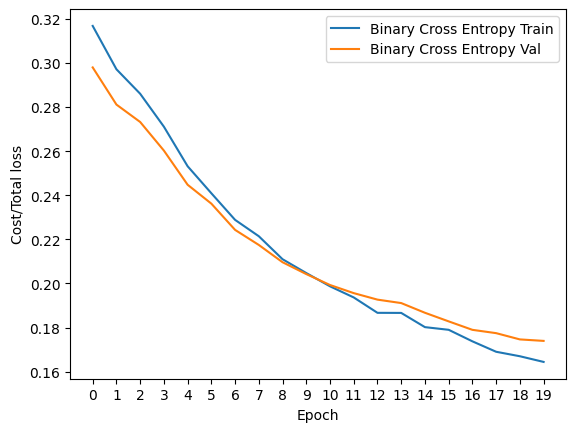

In [188]:
plt.plot(range(len(dict_metrics['loss_train'])), dict_metrics['loss_train'], label="Binary Cross Entropy Train")
plt.plot(range(len(dict_metrics['loss_val'])), dict_metrics['loss_val'], label="Binary Cross Entropy Val")
plt.xlabel('Epoch')
plt.ylabel('Cost/Total loss')
plt.xticks(range(len(dict_metrics['loss_train'])))
plt.legend();

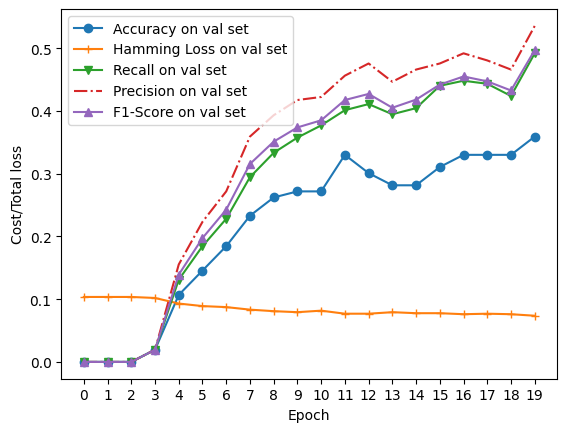

In [191]:
plt.plot(range(len(dict_metrics['accuracy'])), dict_metrics['accuracy'], label="Accuracy on val set", linestyle = 'solid', marker = 'o')
plt.plot(range(len(dict_metrics['hamming'])), dict_metrics['hamming'], label="Hamming Loss on val set", linestyle = 'solid', marker = '+')
plt.plot(range(len(dict_metrics['recall'])), dict_metrics['recall'], label="Recall on val set", linestyle = 'solid', marker = 'v')
plt.plot(range(len(dict_metrics['precision'])), dict_metrics['precision'], label="Precision on val set", linestyle = '-.')
plt.plot(range(len(dict_metrics['f1'])), dict_metrics['f1'], label="F1-Score on val set", linestyle = 'solid', marker = '^')
plt.xlabel('Epoch')
plt.ylabel('Cost/Total loss')
plt.xticks(range(len(dict_metrics['loss_train'])))
plt.legend();

## Évaluation du modèle sur le jeu de test
Après l'entraînement, évalueation du modèle sur un jeu de données de test pour vérifier ses performances

### Métriques

In [190]:
model.eval()
# Code pour évaluer le modèle sur un jeu de données de test

threshold_test = 0.5

y_pred_test = model(inputs_test['input_ids'], attention_mask=inputs_test['attention_mask'])
loss_test = loss_fn(y_pred_test.logits, labels_test)
accuracy_test, hamming_loss_test, recall_test, precision_test, f1score_test = compute_metrics(y_pred_test, y_test, threshold=threshold_test)

print(f"   Loss test {loss_test:.4f}")
print(f"   Accuracy {accuracy_test:.4f}")
print(f"   Hamming Loss {hamming_loss_test:.4f}")
print(f"   Recall {recall_test:.4f}")
print(f"   Precision {precision_test:.4f}")
print(f"   F1-Score {f1score_test:.4f}")

   Loss test 0.1965
   Accuracy 0.3811
   Hamming Loss 0.0772
   Recall 0.5266
   Precision 0.5738
   F1-Score 0.5308


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Enregistrement des expérimentations

In [193]:
# l_cols_results = [
#     'comment',
#     'dataset',
#     'train_size',
#     'val_size',
#     'test_size',
#     'split_method',
#     'split_seed',
#     'batch_size',
#     'learning_rate',
#     'number_epochs',
#     'threshold',
#     'training_time',
#     'bce_loss_train',
#     'bce_loss_val',
#     'bce_loss_test',
#     'accuracy_test',
#     'hamming_loss_test',
#     'recall_test',
#     'precision_test',
#     'f1score_test'
# ]

# df_results = pd.DataFrame(columns=l_cols_results)

df_results = pd.read_csv("results.csv", sep=";")

#### PARAGRAPHE A MODIFIER A CHAQUE ESSAI ####
dict_new_row = {
    'comment': "Suppression des classes avec moins de 20 individus. Le modèle apprend de manière plus continue, mais les métriques restent mauvaises",
    'dataset': FILE_KEY_S3,
    'train_size': len(X_train),
    'val_size': len(X_val),
    'test_size': len(X_test),
    'split_method': 'manuelle, classe réparties à la main',
    'split_seed': random_state,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'number_epochs': n_epochs,
    'threshold': threshold_train,
    'training_time': total_time,
    'bce_loss_train': dict_metrics['loss_train'],
    'bce_loss_val': dict_metrics['loss_val'],
    'bce_loss_test': loss_test.detach().numpy(),
    'accuracy_test': accuracy_test,
    'hamming_loss_test': hamming_loss_test,
    'recall_test': recall_test,
    'precision_test': precision_test,
    'f1score_test': f1score_test
}

df_new_row = pd.DataFrame([dict_new_row])
df_results = pd.concat((df_results, df_new_row))

df_results.to_csv("results.csv", sep=';', index=False)

df_results

,comment,dataset,train_size,val_size,test_size,split_method,split_seed,batch_size,learning_rate,number_epochs,threshold,training_time,bce_loss_train,bce_loss_val,bce_loss_test,accuracy_test,hamming_loss_test,recall_test,precision_test,f1score_test
0,Le modèle apprend mais les métriques sont mauv...,project-1-at-2024-12-27-15-41-3fe0002a_prepare...,909,101,253,train_test,42,32,0.0005,20,0.5,NaN,"[array(0.24619417, dtype=float32), array(0.235...","[array(0.24225658, dtype=float32), array(0.231...",0.166751,0.359684,0.063488,0.459157,0.522398,0.475362
0,Suppression des classes avec moins de 20 indiv...,project-1-at-2024-12-27-15-41-3fe0002a_prepare...,882,103,244,"manuelle, classe réparties à la main",42,32,0.0005,20,0.5,None,"[0.3167946, 0.29714128, 0.28603402, 0.27109748...","[0.2979763, 0.28112873, 0.27323103, 0.26025823...",0.19646698,0.381148,0.077186,0.526639,0.573770,0.530757


### Observation des prédictions

In [205]:
probabilities_test = F.sigmoid(y_pred_test.logits).detach().numpy()

df_probas_pred_test = pd.DataFrame(probabilities_test, columns=df_data_modified.drop(columns=['text'], axis=1).columns)
df_probas_pred_test.head()

,autre,environnement,économie,institutions,immigration,international,outre-mer,pouvoir d’achat,social,santé,sécurité / justice,vie politique
0,0.008957,0.005598,0.029584,0.039204,0.043045,0.861884,0.008044,0.005801,0.072608,0.012526,0.074422,0.077775
1,0.074514,0.006606,0.015772,0.112506,0.056937,0.019209,0.111743,0.005052,0.250401,0.034916,0.167008,0.070109
2,0.013113,0.020182,0.166942,0.067127,0.069968,0.137220,0.015176,0.018714,0.096923,0.054682,0.121153,0.214031
3,0.003920,0.003502,0.043811,0.489463,0.061663,0.041963,0.007912,0.008199,0.107717,0.033887,0.058599,0.460847
4,0.006134,0.018918,0.182617,0.129456,0.076817,0.720718,0.018290,0.009273,0.036797,0.015834,0.070663,0.247781


In [197]:
for text in X_test[:5]:
    print(text)
    print("-------------------------------")

Il faut continuer à accorder le statut de réfugié aux Syriens.

Regardez par exemple ces hommes et ces femmes qui sortent des prisons syriennes, qui sommes-nous pour leur interdire d’être réfugiés chez nous ?
#Syrie #Retailleau
-------------------------------
2h12 ce samedi matin, la loi Asile Immigration vient d’être adoptée en commission des lois. Tristesse et inquiétude.
-------------------------------
Un sérieux tour de vis migratoire et pénal doit être engagé, sans que l'on se paye de mots et de promesses : notre pays ne peut plus accueillir une immigration de masse qui bouleverse son identité et pèse lourdement sur ses comptes publics.
-------------------------------
🔴 Communiqué de presse

« Nous appelons le Président de la République et le Gouvernement à prendre acte de cette défaite et à mettre fin à ce naufrage républicain en retirant la loi immigration. »

➡️ www.parti-socialiste.fr/loi_immigrat...
-------------------------------
Benjamin Haddad 

C’est la France d’Emmanuel 

In [206]:
l_labels = df_data_modified.drop(columns=['text'], axis=1).columns.to_list()
ser_labels_pred_test = (df_probas_pred_test > threshold_test).apply(lambda row: list(compress(l_labels, row)), axis=1)
ser_labels_pred_test

0      [international]
1                   []
2                   []
3                   []
4      [international]
            ...       
239    [vie politique]
240    [vie politique]
241    [vie politique]
242    [vie politique]
243            [autre]
Length: 244, dtype: object

In [207]:
df_test = pd.DataFrame(np.array(y_test).astype(bool), columns=df_data_modified.drop(columns=['text'], axis=1).columns)
ser_labels_test = df_test.apply(lambda row: list(compress(l_labels, row)), axis=1)
ser_labels_test

0                     [immigration]
1                     [immigration]
2                     [immigration]
3                     [immigration]
4      [immigration, vie politique]
                   ...             
239                 [vie politique]
240                 [vie politique]
241                 [vie politique]
242                 [vie politique]
243                 [vie politique]
Length: 244, dtype: object

### Conclusions des observations

On peut penser que certaines classes portent le poids d'un apprentissage sémantique propre à leur source comme évoqué en projet tutoré.  
Cela semble entraîner de mauvaises prédictions

### Matrices de confusion par classe

In [208]:
y_pred_test_np_threshold = (df_probas_pred_test > threshold_test).astype(int).to_numpy()

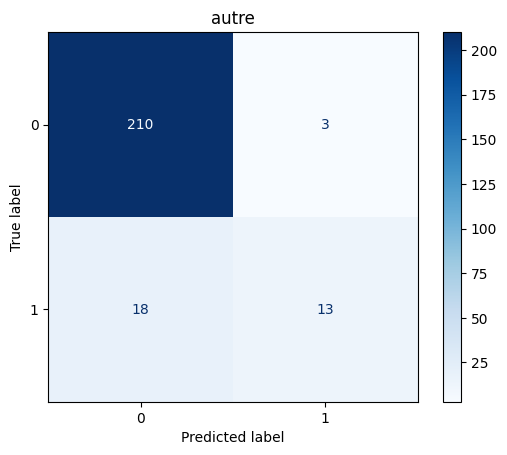

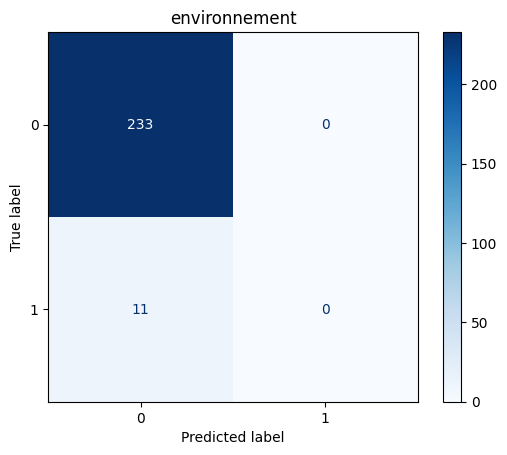

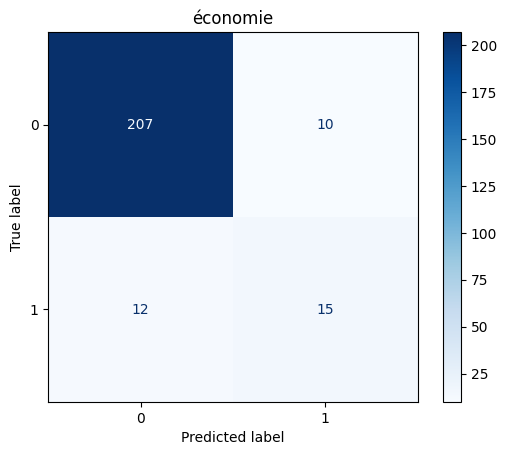

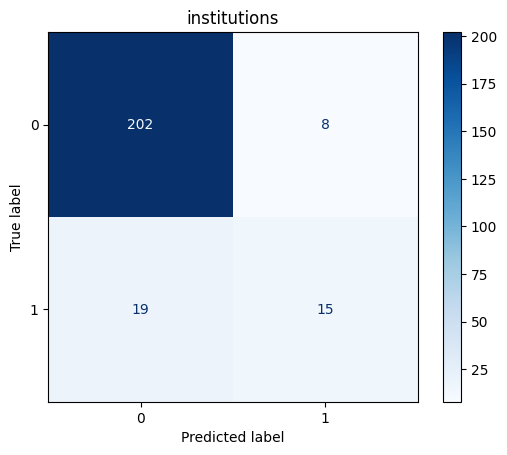

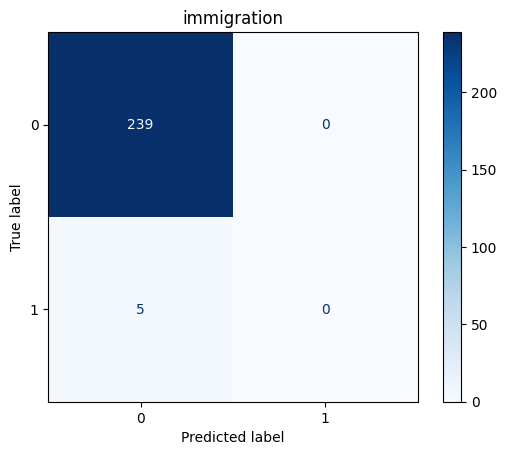

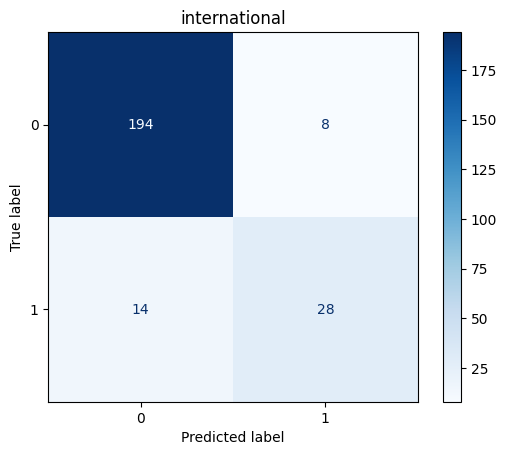

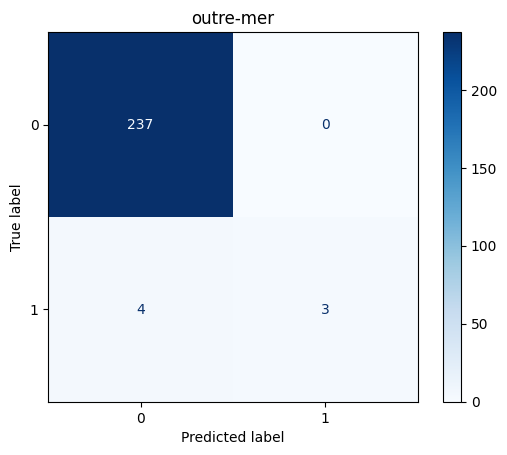

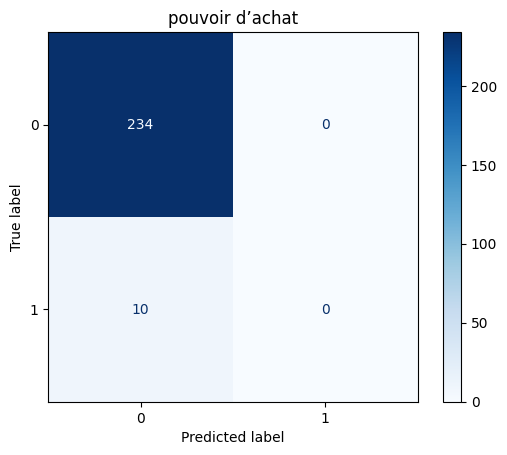

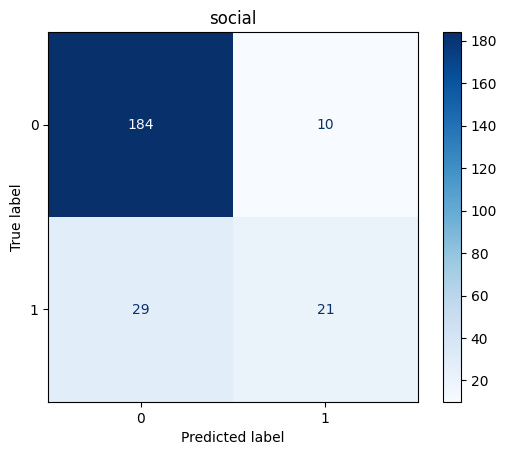

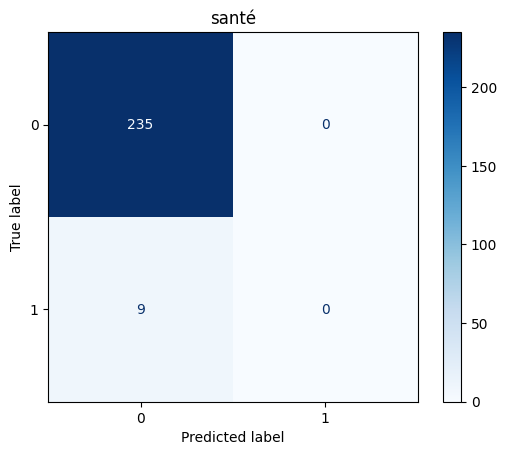

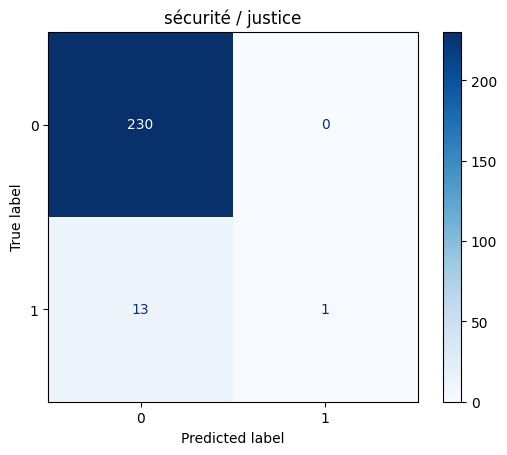

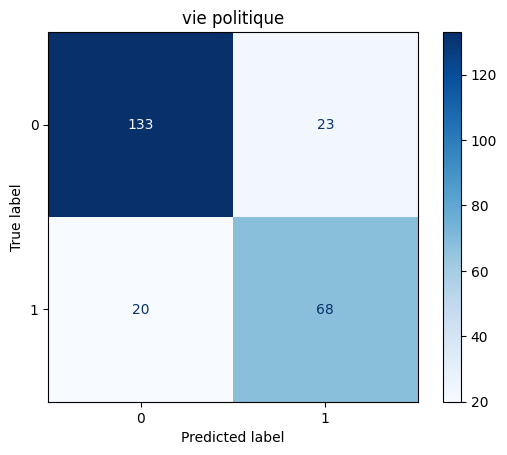

In [209]:
arr_cm = multilabel_confusion_matrix(y_test, y_pred_test_np_threshold)

for label, cm in zip(l_labels, arr_cm):
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(label)
    plt.show()